# Pré-processamento e criação do modelo

Nesta etapa do projeto utilizaremos das informações coletadas na etapa de EDA para tratarmos nossas features visando uma melhor aplicação ao modelo. Trazendo nossos resultados do EDA, temos:

- Vamos excluir as variáveis `score_8` e `produto`
- Há variáveis discretas dentre as numéricas
- Podemos aplicar a transformação log as variávels `score_3` e `valor_compra`
- Podemos retirar os outliers relativos a `score_6` (> 483) e `score_5` (> 10)
- A variável `pais` pode ser agrupada em continentes
- Podemos transformar a variável `data_compra` em hora do dia, dia da semana e turno de compra.
- Agrupar as categorias de produto que possuem menos que 3 ocorrências em coluna outros, se torna necessário testarmos com ou sem a adição dessa coluna.

In [1]:
import os
import pandas as pd
import numpy as np
from tabulate import tabulate

import optuna
import shap
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
)


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
import pycountry_convert as pc


import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)

c:\Users\renne\anaconda3\envs\fraud-detection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vamos carregar e consultar novamente nossos dados, isso servirá como um parâmetro para como está o estado das variáveis e como queremos transformá-las. Queremos aplicar nossos dados a modelos de classificação que são baseados em árvores de decisão, prezando uma aderência a diversos modelos, vamos transformar as variáveis para valor numérico.

In [2]:
df = pd.read_csv("../artifacts/data_ingestion/dados.csv")
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


Vamos remover os outliers identificados na etapa de análise exploratória de dados. Para o `score_5` foi realizado uma escolha empírica de um limiar de 10, podemos verificar a aderência do modelo com e sem outliers.

In [3]:
df_sem_outliers = df[df["score_5"] < 10]
df_sem_outliers = df_sem_outliers[df_sem_outliers["score_6"] < 483] # 483 é o quantil 0.99


Após a remoção dos outliers, antes de qualquer processamento a ser aplicado a nossos dados devemos dividi-los em treino e teste para evitar vazamento de dados, ou seja nossos dados de teste não devem ser utilizados em treino, garantindo que possamos avaliar o modelo com qualidade e se ele se adapta a novos dados externos.

In [4]:
X = df_sem_outliers.drop("fraude", axis=1)
y = df_sem_outliers["fraude"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Pipelines de pré-processamento

Iremos construir as etapas de pré processamento como classes para serem aplicadas a um Pipeline, criamos uma `CustomClass` para carregar a herança do `BaseEstimator` e `TransformerMixin` para outros componentes, mas principalmente acoplando o comportamento da inicialização de colunas, além da sobrescrita do método fit para uma função dummy.

Após a utilização desse notebook os códigos aqui apresentados serão repassados para o arquivo `src/fraud_detection/components/data_transformation`. Neste arquivo também será apresentado uma melhor documentação acerca das funções.

In [5]:
# Classe que servirá para o pai dos transformadores customizados
class CustomProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    # O método fit é declarado para sobrescrever o fit padrão das classes do sklearn
    def fit(self, X, y=None):
        return self

In [6]:
# Removedor de colunas que foram passadas na inicialização
class DropColumns(CustomProcessor):
    def __init__(self):
        self.drop_columns = ["score_fraude_modelo", "produto", "score_8"]

    def transform(self, X):
        return X.drop(self.drop_columns, axis=1)

Vamos processar as colunas de documentos, os valores nulos serão preeenchidos com "N" transforma os valores de texto para 0 ou 1 (N ou Y).

In [7]:
class DocumentsProcessor(CustomProcessor):
    def __init__(self):
        self.document_columns = [
            "entrega_doc_1",
            "entrega_doc_2",
            "entrega_doc_3"
        ]

    def transform(self, X):
        X_new = X.copy()
        X_new[self.document_columns] = X_new[self.document_columns].fillna("N")
        X_new[self.document_columns] = (X_new[self.document_columns] == "Y").astype(int)

        return X_new

O processador de datas, vamos criar as colunas de hora e dia da semana. Importante retirarmos a coluna inicial data_compra para evitar informações repetidas.

In [8]:
def hour_to_period(hour):
    if 6 <= hour < 12:
        return "Manhã"
    elif 12 <= hour < 18:
        return "Tarde"
    elif 18 <= hour < 24:
        return "Noite"
    else:
        return "Madrugada"

class DateProcessor(CustomProcessor):
    def __init__(self):
        self.date_column = "data_compra"

    def transform(self, X):
        X_new = X.copy()
        date = pd.to_datetime(X_new[self.date_column])

        X_new["hora_compra"] = date.dt.hour
        X_new["dia_compra"] = date.dt.dayofweek
        X_new["turno_compra"] = X_new["hora_compra"].apply(hour_to_period)

        X_new = X_new.drop(self.date_column, axis=1)


        return X_new

Para variáveis categóricas vamos aplicar o OneHotEncoding para variáveis com menor cardinalidade.

In [9]:
class OneHotEncoderProcessor(CustomProcessor):
    def __init__(self):
        self.columns_to_encode = ["score_1", "continente", "turno_compra"]

    def transform(self, X):
        X_encoded = pd.get_dummies(
            X, columns=self.columns_to_encode, dtype=int
        )

        return X_encoded

A classe `ImputeValuesProcessor` é a de maior complexidade devido a necessidade de processar variáveis discretas e contínuas, e aplicá-las ao `ColumnTransformer`. Esta abordagem foi escolhida pois as transformações de saída do `ColumnTransformer` transforma o DataFrame em um array Numpy sem as informações de rótulos de colunas.

Precisamos resgatar os nomes de colunas e transformar novamente em um DataFrame para aplicá-los ao pipeline de transformação.

Para o preenchimento de valores vazios iremos utilizar a mediana para variáveis contínuas e a moda para variáveis discretas.


In [10]:
class ImputeValuesProcessor(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.discrete_columns = ["score_4", "score_7"]
        self.continuous_columns = [
            "score_2",
            "score_3",
            "score_5",
            "score_6",
            "score_9",
            "score_10",
            "valor_compra",
        ]

        self.numerical_imputer = ColumnTransformer(
            transformers=[
                (
                    "discrete",
                    SimpleImputer(strategy="most_frequent"),
                    self.discrete_columns,
                ),
                (
                    "continuous",
                    SimpleImputer(strategy="median"),
                    self.continuous_columns,
                ),
            ],
            remainder="passthrough",
        )

    def _get_column_names(self, X):
        transformed_columns = (
            self.discrete_columns
            + self.continuous_columns
            + [
                col
                for col in X.columns
                if col not in self.discrete_columns + self.continuous_columns
            ]
        )
        return transformed_columns
    
    def fit(self, X, y=None):

        self.numerical_imputer.fit(X)
        return self

    def transform(self, X):
        X_transformed = self.numerical_imputer.transform(X)
        X_transformed = pd.DataFrame(
            X_transformed, columns=self._get_column_names(X)
        )

        return X_transformed

Aqui iremos aplicar as transformações numéricas as colunas possívels, sendo a transformação log e raiz cúbica.

In [11]:
class TransformColumns(CustomProcessor):
    def __init__(self):
        self.log_columns = ["score_3", "valor_compra"]
        
    def transform(self, X):
        X_new = X.copy()

        for col in self.log_columns:
            X_new[f"log_{col}"] = np.log1p(X_new[col].astype(float))

        X_new = X_new.drop(
            self.log_columns,
            axis=1
        )

        return X_new

O processador de país irá transformar a coluna em continentes, agrupando em apenas 5 categorias.

In [12]:
class CountryProcessor(CustomProcessor):
    def __init__(self):
        self.country_column = "pais"
    def transform(self, X):
        X_new = X.copy()
        X_new[self.country_column] = X_new[self.country_column].fillna(
            X_new[self.country_column].mode()[0]
        )

        X_new["continente"] = X_new[self.country_column].apply(
            lambda x: pc.country_alpha2_to_continent_code(x)
        )

        X_new = X_new.drop(self.country_column, axis=1)

        return X_new

In [13]:
pipeline = Pipeline(
    [
        ("dropper", DropColumns()),
        ("imputer", ImputeValuesProcessor()),
        ("docs", DocumentsProcessor()),
        ("date", DateProcessor()),
        ("country", CountryProcessor()),
        ("encoder", OneHotEncoderProcessor()),
        ("transform", TransformColumns()),
    ]
)

In [14]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

Vamos tratar as colunas categoricas restantes separadamente, juntando os valores não frequentes de `categoria_produto` em uma categoria outros.

In [15]:
def group_non_frequent_categories(series, threshold=2):
    frequent_categories = series.value_counts()
    valid_categories = frequent_categories[frequent_categories > threshold].index

    series_reduced = series.copy()
    series_reduced.loc[~series_reduced.isin(valid_categories)] = "Outros"

    return series_reduced

X_train_transformed["categoria_produto_reduzida"] = group_non_frequent_categories(
    X_train_transformed["categoria_produto"]
)
X_test_transformed["categoria_produto_reduzida"] = group_non_frequent_categories(
    X_test_transformed["categoria_produto"]
)   

X_train_transformed = X_train_transformed.drop("categoria_produto", axis=1)
X_test_transformed = X_test_transformed.drop("categoria_produto", axis=1)

Vamos agora aplicar o TargetEncoding para estas colunas categóricas.

Devemos utilizar os dados de treino para fazer o fit do TargetEncoding para apenas transformarmos os dados de teste.

In [16]:
category_column = ["categoria_produto_reduzida"]

# Transforma a série para um dataframe para ser aplicado ao fit transform do target encoder
target_encoder = TargetEncoder(shuffle=False)

X_train_transformed[category_column] = target_encoder.fit_transform(
    X_train_transformed[category_column], y_train
)
X_test_transformed[category_column] = target_encoder.transform(X_test_transformed[category_column])

Por último realizamos as últimas conversões as colunas que foram transformadas para garantirmos que sejam numéricas.

In [17]:
def convert_to_numeric(df):
    new_df = df.copy()
    for col in new_df.select_dtypes(include=["object"]).columns:
        try:
            new_df[col] = pd.to_numeric(new_df[col], errors="coerce")
        except ValueError as e:
            print(e)
            pass

    return new_df


X_train_transformed = convert_to_numeric(X_train_transformed)
X_test_transformed = convert_to_numeric(X_test_transformed)

Verificamos que todas as colunas foram alteradas e transformadas para valores numericos a seguir.

In [18]:
X_train_transformed.dtypes

score_4                       float64
score_7                       float64
score_2                       float64
score_5                       float64
score_6                       float64
score_9                       float64
score_10                      float64
entrega_doc_1                   int32
entrega_doc_2                   int32
entrega_doc_3                   int32
hora_compra                     int32
dia_compra                      int32
score_1_1                       int32
score_1_2                       int32
score_1_3                       int32
score_1_4                       int32
continente_AF                   int32
continente_AS                   int32
continente_EU                   int32
continente_NA                   int32
continente_OC                   int32
continente_SA                   int32
turno_compra_Madrugada          int32
turno_compra_Manhã              int32
turno_compra_Noite              int32
turno_compra_Tarde              int32
log_score_3 

In [19]:
X_train_transformed, X_test_transformed = X_train_transformed.align(
    X_test_transformed, join='left', axis=1, fill_value=0
)

### Treinamento de modelos

Foram escolhidos modelos de classificação que funcionam baseando-se em árvores de decisão. Fizemos uma comparação entre os seguintes modelos:
- Random Forest
- XGBoost
- LightGBM
- DecisionTree

Tendo em vista que estamos lidando com dados desbalanceados, designamos hiperparâmetros dos modelos para lidar com essa problemática no conjunto de dados. 

In [20]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weight

18.729433272394882

In [21]:
models = [
    (
        "Random Forest",
        RandomForestClassifier(
            n_estimators=100,
            class_weight="balanced",
            random_state=42
        ),
    ),
    (
        "Decision Tree",
        DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42
        ),
    ),
    (
        "XGBoost",
        XGBClassifier(
            scale_pos_weight=round(scale_pos_weight),
            random_state=42
        )
    ),
    (
        "LightGBM",
        LGBMClassifier(
            scale_pos_weight=round(scale_pos_weight),
            random_state=42,
            verbosity=-1
        )
    )
]

In [22]:
def evaluate_model_with_kfold(models, X_train, y_train, metric):
    results = []
    for name, model in models:
        kfold = KFold(n_splits=4, random_state=42, shuffle=True)
        cv_results = cross_val_score(
            model, X_train, y_train, cv=kfold, scoring=metric
        )

        results.append(cv_results)
        msg = "%s: %f (%f)" % (
            name,
            cv_results.mean(),
            cv_results.std(),
        )
        print(msg)

In [23]:
evaluate_model_with_kfold(models, X_train_transformed, y_train, "roc_auc")

Random Forest: 0.766075 (0.004223)
Decision Tree: 0.562440 (0.002677)
XGBoost: 0.757957 (0.002621)
LightGBM: 0.785909 (0.003119)


In [24]:
evaluate_model_with_kfold(models, X_train_transformed, y_train, "recall")

Random Forest: 0.071485 (0.004035)
Decision Tree: 0.170453 (0.005926)
XGBoost: 0.508942 (0.006839)
LightGBM: 0.663082 (0.005837)


In [25]:
evaluate_model_with_kfold(models, X_train_transformed, y_train, "precision")

Random Forest: 0.871190 (0.027241)
Decision Tree: 0.166471 (0.004605)
XGBoost: 0.151615 (0.005136)
LightGBM: 0.131867 (0.004274)


In [26]:
evaluate_model_with_kfold(models, X_train_transformed, y_train, "f1")

Random Forest: 0.132096 (0.006972)
Decision Tree: 0.168358 (0.003788)
XGBoost: 0.233603 (0.006630)
LightGBM: 0.219966 (0.006212)


Os modelos que obtiveram o melhor desempenho foram `LightGBM` e `RandomForest`, enquanto o pior desempenho foi obtido pela `Decision Tree`. Vamos utilizar o `LightGBM` por apresentar uma maior métrica de AUC e Recall. Além de ser um modelo mais eficiente e de escalabilidade para conjuntos maiores. Vamos realizar uma busca dos melhores hiperparâmetros utilizando o otimizador Optuna.

In [27]:
def get_metrics(y_true, y_pred):
    metrics = [
        ("ROC_AUC", roc_auc_score(y_true, y_pred)),
        ("Log-loss", log_loss(y_true, y_pred)),
        ("Precision", precision_score(y_true, y_pred)),
        ("Recall", recall_score(y_true, y_pred)),
        ("F1", f1_score(y_true, y_pred)),
    ]

    print("Métricas para o limiar de 0.5 (50)")
    for name, value in metrics:
        print(f"{name}: {value}")

    return metrics

In [28]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "verbosity": -1,
        
        # Tuning de hiperparâmetros a partir do Optuna
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
    }

    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_train_transformed, y_train, cv=3, scoring="roc_auc", n_jobs=-1)
    
    return scores.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Melhores Hiperparâmetros:", study.best_params)

Melhores Hiperparâmetros: {'max_depth': 8, 'num_leaves': 54, 'learning_rate': 0.014943986178804566, 'n_estimators': 455, 'subsample': 0.6507631810615698, 'colsample_bytree': 0.5601655044537822, 'reg_lambda': 0.14502516392192977}


In [29]:
study.best_value

0.7934745333617408

In [30]:

best_params = study.best_params

X_test_transformed["continente_AS"] = 1

model = LGBMClassifier(**best_params)
model.set_params(scale_pos_weight=scale_pos_weight, random_state=42)

model.fit(X_train_transformed, y_train)

y_pred = model.predict_proba(X_test_transformed)[:, 1]

new_model_results = get_metrics(y_test, y_pred > 0.5)
metrics_dict = {metric: value for metric, value in new_model_results}


Métricas para o limiar de 0.5 (50)
ROC_AUC: 0.7211274862745015
Log-loss: 8.34084071149488
Precision: 0.1323549395298274
Recall: 0.668496911461908
F1: 0.22096188747731396


In [31]:
mlflow.set_registry_uri(os.getenv("MLFLOW_TRACKING_URI"))
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

new_model_results = []
metrics_dict = {}
with mlflow.start_run():
    best_params = study.best_params
    mlflow.log_params(best_params)

    model = LGBMClassifier(**best_params)
    model.set_params(scale_pos_weight=scale_pos_weight, random_state=42)

    model.fit(X_train_transformed, y_train)

    y_pred = model.predict_proba(X_test_transformed)[:, 1]

    new_model_results = get_metrics(y_test, y_pred > 0.5)
    metrics_dict = {metric: value for metric, value in new_model_results}

    mlflow.log_metrics(metrics_dict)

    try:
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(
                model,
                "model",
                registered_model_name="LGBMClassifierModel",
                input_example=X_train_transformed.head(1),
            )
        else:
            mlflow.sklearn.log_model(model, "model")
    except mlflow.exceptions.MlflowException as e:
        print(f"Model registry não disponível. Log em modo local, erro: {e}")
        mlflow.sklearn.log_model(model, "model")

Métricas para o limiar de 0.5 (50)
ROC_AUC: 0.7211274862745015
Log-loss: 8.34084071149488
Precision: 0.1323549395298274
Recall: 0.668496911461908
F1: 0.22096188747731396


c:\Users\renne\anaconda3\envs\fraud-detection\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\renne\anaconda3\envs\fraud-detection\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inp

🏃 View run grandiose-snipe-718 at: https://dagshub.com/renneruan/fraud-detection.mlflow/#/experiments/0/runs/1f42a847d4104ef38e8387a23306ea2b
🧪 View experiment at: https://dagshub.com/renneruan/fraud-detection.mlflow/#/experiments/0


Após encontrarmos os melhores hiperparâmetros que se ajustam ao modelo, vamos extrair o vetor de predições dos nossos dados de teste, elencando adicionalmente as métricas de Precisão, Recall e Log-loss, além da visualização gráfica do modelo comparando com o modelo base fornecido em conjunto com a amostra.

In [32]:
new_model_results

[('ROC_AUC', 0.7211274862745015),
 ('Log-loss', 8.34084071149488),
 ('Precision', 0.1323549395298274),
 ('Recall', 0.668496911461908),
 ('F1', 0.22096188747731396)]

Vamos utilizar o SHAP para verificarmos quais features tiveram mais influência no modelo.

In [33]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_transformed)

c:\Users\renne\anaconda3\envs\fraud-detection\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


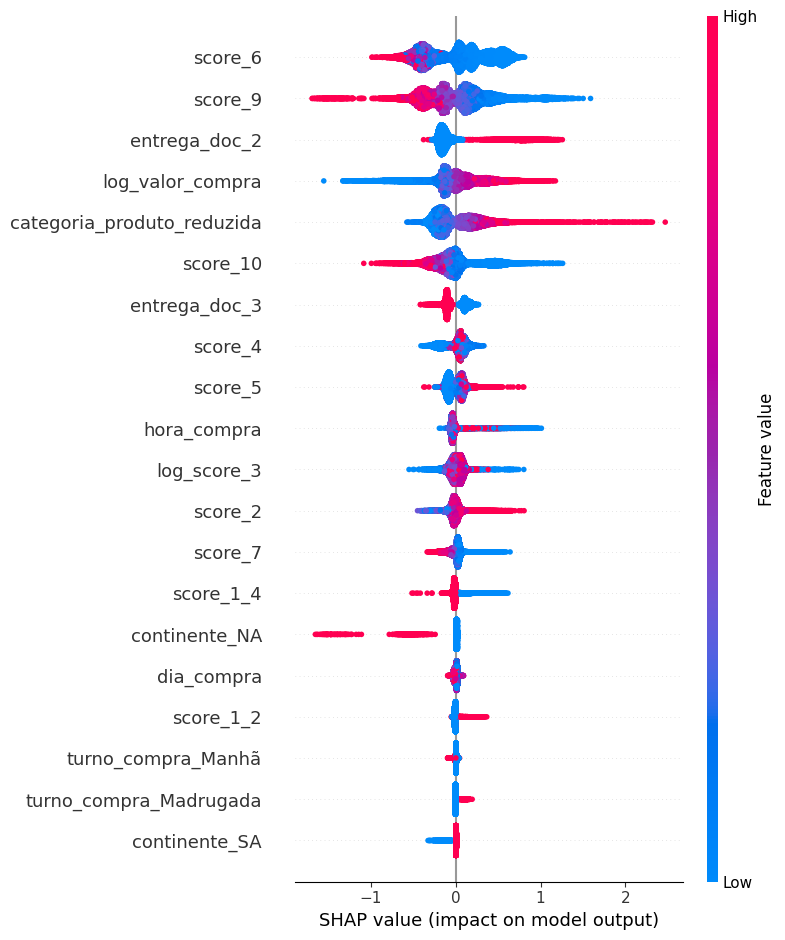

In [ ]:
shap.summary_plot(shap_values, X_test_transformed)

### Comparação de Lucro e Métricas de Negócio

Vamos construir um DataFrame contendo agora as colunas de predição do modelo atual e do modelo antigo.

In [35]:
X_test_evaluate = X_test

# Multiplicamos por 100 pois a probabilidade vem em porcentagem
X_test_evaluate["score_new_model"] = y_pred * 100
X_test_evaluate["fraude"] = y_test

Temos as seguintes métricas com o limiar padrão para o modelo antigo.

In [36]:
old_model_results = get_metrics(
    y_test, X_test_evaluate["score_fraude_modelo"] > 50
)

Métricas para o limiar de 0.5 (50)
ROC_AUC: 0.6518338740587362
Log-loss: 16.214118278853835
Precision: 0.07888401076334797
Recall: 0.7645847632120796
F1: 0.1430130303613839


In [37]:
def compare_metrics(results1, results2):
    headers = ["Métrica", "Model Novo", "Modelo Antigo", "Diferença"]
    table = []

    for (metric1, value1), (_, value2) in zip(results1, results2):
        difference = value1 - value2
        table.append(
            [metric1, f"{value1:.4f}", f"{value2:.4f}", f"{difference:.4f}"]
        )

    print(tabulate(table, headers=headers, tablefmt="grid"))

In [38]:
compare_metrics(new_model_results, old_model_results)

+-----------+--------------+-----------------+-------------+
| Métrica   |   Model Novo |   Modelo Antigo |   Diferença |
+===========+==============+=================+=============+
| ROC_AUC   |       0.7211 |          0.6518 |      0.0693 |
+-----------+--------------+-----------------+-------------+
| Log-loss  |       8.3408 |         16.2141 |     -7.8733 |
+-----------+--------------+-----------------+-------------+
| Precision |       0.1324 |          0.0789 |      0.0535 |
+-----------+--------------+-----------------+-------------+
| Recall    |       0.6685 |          0.7646 |     -0.0961 |
+-----------+--------------+-----------------+-------------+
| F1        |       0.221  |          0.143  |      0.0779 |
+-----------+--------------+-----------------+-------------+


Para o limiar padrão de 0.5, vemos uma melhoria do novo modelo principalmente no que tange a precisão e a log loss, mas com perdas para o Recall. Como devemos capturar o maior número de transações fraudulentas existentes, a queda no Recall pode ser um fator de melhoria e análise de adoção ao novo modelo.  

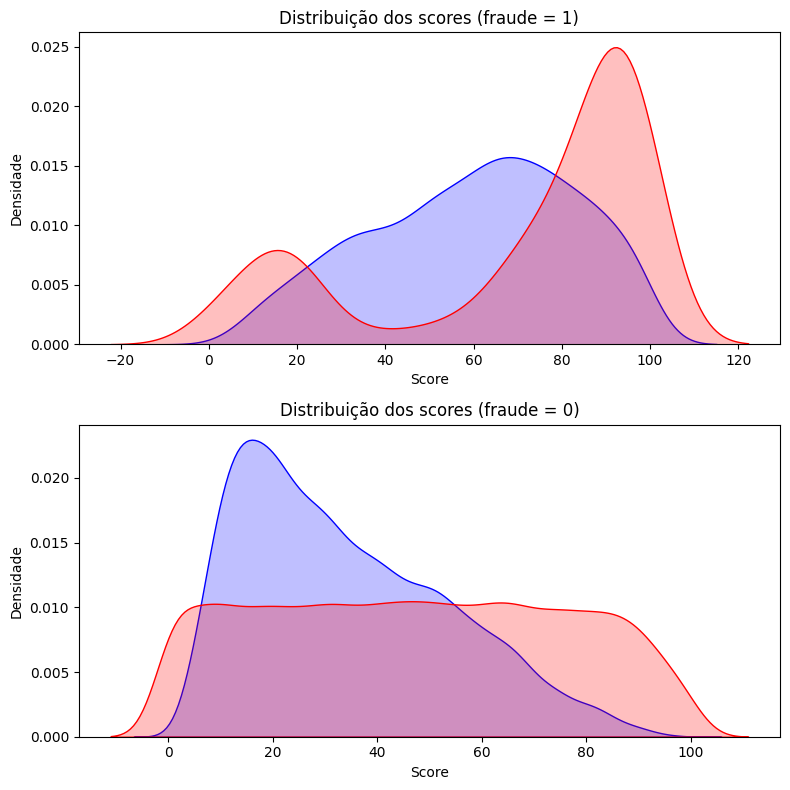

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

# Access the axes directly
sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 1],
    x="score_new_model",
    ax=ax[0],
    color="b",
    fill=True,
)
sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 1],
    x="score_fraude_modelo",
    ax=ax[0],
    color="r",
    fill=True,
)

sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 0],
    x="score_new_model",
    ax=ax[1],
    color="b",
    fill=True,
)
sns.kdeplot(
    data=X_test_evaluate[X_test_evaluate["fraude"] == 0],
    x="score_fraude_modelo",
    ax=ax[1],
    color="r",
    fill=True,
)

# Add titles and labels
ax[0].set_title("Distribuição dos scores (fraude = 1)")
ax[0].set_xlabel("Score")
ax[0].set_ylabel("Densidade")

ax[1].set_title("Distribuição dos scores (fraude = 0)")
ax[1].set_xlabel("Score")
ax[1].set_ylabel("Densidade")

plt.tight_layout()
plt.show()

Percebemos um comportamento mais homogêneo nas predições do novo modelo (em azul), classificando também em valores intermediários de score.

Vamos comparar diretamente o modelo nas métricas de negócio levantadas no notebook de entendimento do negócio. Vamos reaproveitar o código construído para achar o limiar ótimo que gere maior rendimento para a empresa. Agora aplicados unicamente aos dados de teste.

In [40]:
%pwd
%cd ..
from src.fraud_detection.utils.base_metrics import BaseMetrics


c:\Users\renne\Documents\Estudos Dados\Repositórios\ML\fraud-detection


c:\Users\renne\anaconda3\envs\fraud-detection\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [41]:
bm_old = BaseMetrics(
    X_test_evaluate, "score_fraude_modelo", "fraude", "valor_compra"
)

bm_old.find_best_threshold()
bm_old.show_all_metrics()

O limiar ótimo encontrado para a amostra é de: 79
Ganhos por transações aprovadas: R$ 89287.09
Prejuízos com transações fraudulentas aprovadas: R$ 33122.63
Receita gerada com limiar ótimo: R$ 56164.46
Taxa de pressão de entrada é de 4.909195053741703%
Taxa de aprovação total é de 80.24%
Taxa de declínio total é de 18.77%
A precisão do modelo é de 15.31%
A revocação do modelo é de 59.32%
A taxa de falsos positivos é de 16.88%


In [42]:
bm_new = BaseMetrics(
    X_test_evaluate, "score_new_model", "fraude", "valor_compra"
)

bm_new.find_best_threshold()
bm_new.show_all_metrics()

O limiar ótimo encontrado para a amostra é de: 60
Ganhos por transações aprovadas: R$ 92414.77
Prejuízos com transações fraudulentas aprovadas: R$ 28970.02
Receita gerada com limiar ótimo: R$ 63444.75
Taxa de pressão de entrada é de 4.909195053741703%
Taxa de aprovação total é de 85.50%
Taxa de declínio total é de 14.50%
A precisão do modelo é de 18.22%
A revocação do modelo é de 53.81%
A taxa de falsos positivos é de 12.47%


---
## Conclusão

Com o novo modelo percebemos as seguintes alterações na predição de fraudes:

- Melhoria da receita gerada para a amostra de **6754.69** para o intervalo da amostra.  
- Comportamento do modelo se tornou mais arriscado (limiar foi de 72 para 65), deixando de resgatar mais fraudes, porém permitindo aprovar mais transações legítimas. Este limiar no novo modelo traz um aumento de precisão de **7.04%**, enquanto a revocação diminui em **19.54%**.  
- Tal comportamento também foi refletido na diminuição de **13.43%** dos falsos positivos.  
- Sem considerar os limiares ótimos calculados, a métrica de log loss caiu de 16.1307 para 9.2392.  

Como dificuldades apresentadas na criação do modelo temos principalmente o desbalanceamento dos dados entre as classes, em que podemos seguir a experimentação ao aplicar técnicas de Oversampling para ps casos de fraude. Além disse o TargetEncoder talvez não seja a melhor alternativa para lidar com a grande cardinalidade dos valores de `categoria_produto`, se obtivessemos informações da hierarquia anterior esta poderia ter maior aplicabilidade ao modelo.

A anonimização das informações também torna arriscado lidarmos com casos de possíveis outliers, a ausência de semântica não nos permite identificar se valores extremos podem ser possíveis.

Considerando a melhoria da receita podemos concluir que o modelo possui um comportamento melhor para o negócio, porém a análise de fraudes em um cenário real é mais extensa e complexa, por exemplo, deveríamos levar em conta a experiência do usuário no que tange a lidar com o tratamento de uma transação fraudulenta, comparado a lidar com o declínio de transações, tais fatores e métricas podem gerar impacto nas reclamações e satisfações mesmo com uma métrica monetária vantajosa.